<a href="https://colab.research.google.com/github/tpeng2/ML_projects/blob/main/Car_sales_TS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import pandas as pd
import torch as tch
import math
from pandas import read_csv
import matplotlib.pyplot as plt

## Data preparation
### 1. Car sales data in Canada

[Stats Canada](https://www150.statcan.gc.ca/t1/tbl1/en/dtl!downloadDbLoadingData.action?pid=2010000101&latestN=0&startDate=19460101&endDate=20210701&csvLocale=en&selectedMembers=%5B%5B%5D%2C%5B%5D%2C%5B%5D%2C%5B%5D%2C%5B1%5D%5D&checkedLevels=0D1%2C1D1%2C1D2%2C2D1%2C3D1) has recorded and published car sales in Canada (seasonally unadjusted) from Jan 1946 to July 2021. We are interested in four type of information as shown below:

*Date*, *Type of vehicle* , *Units*, and  *Value of sales*

Correspondingly, in the .csv file, these are labeled as:
* 'REF_DATE', (in a format of '1946-01')
* 'UOM', ('Units' or 'Dollars' for units or value of sales)
* 'VALUE', (Note: the numbers of 'UOM', not the value of sales per se)
* 'SCALAR_FACTOR' (if it's in dolloars, then 'VALUE' * 'SCALAR_FACTOR' is the real number)

In [5]:
# load data from Stat Canada for all post-war era (1946 to 2021)
path_CSdata = 'https://www150.statcan.gc.ca/t1/tbl1/en/dtl!downloadDbLoadingData.action?pid=2010000101&latestN=0&startDate=19460101&endDate=20210701&csvLocale=en&selectedMembers=%5B%5B%5D%2C%5B%5D%2C%5B%5D%2C%5B%5D%2C%5B1%5D%5D&checkedLevels=0D1%2C1D1%2C1D2%2C2D1%2C3D1'
CS_df_full = pd.read_csv(path_CSdata)

In [6]:
# subsets
CS_df_total = CS_df_full.loc[CS_df_full['Vehicle type'] == 'Total, new motor vehicles']
CS_df_truck = CS_df_full.loc[CS_df_full['Vehicle type'] == 'Trucks']
CS_df_psg = CS_df_full.loc[CS_df_full['Vehicle type'] == 'Passenger cars']


# extrct useful columns and separate unit and value

def get_unit_and_value(DF_orig, col_used):
    DF_ext = DF_orig[col_used]
    if np.mod(len(DF_ext),2)!=0:
        print('Data integrity is damaged. Check length.')
    else:
        len_ts = len(DF_ext)/2 # First half are unites and second half are values
        DF_u = DF_ext[DF_ext['UOM'] =='Units'].sort_values('REF_DATE', ascending=True)
        DF_v = DF_ext[DF_ext['UOM'] =='Dollars'].sort_values('REF_DATE', ascending=True)
    return DF_u, DF_v

# 
col_used = ['REF_DATE','UOM','VALUE','SCALAR_FACTOR']
# total sales
CS_df_u, CS_df_v = get_unit_and_value(CS_df_total, col_used) 
# truck sales
CS_df_truck_u, CS_df_truck_v = get_unit_and_value(CS_df_truck, col_used) 
# passenger car sales
CS_df_psg_u, CS_df_psg_v = get_unit_and_value(CS_df_psg, col_used) 

print(' === An example of the extracted data frame for units=== ')
print(CS_df_psg_u.head())
print(' ===An example of the extracted data frame for values=== ')
print(CS_df_psg_v.head())

 === An example of the extracted data frame for units=== 
     REF_DATE    UOM  VALUE SCALAR_FACTOR
1814  1946-01  Units   1102         units
1815  1946-02  Units   1609         units
1816  1946-03  Units   4734         units
1817  1946-04  Units   5947         units
1818  1946-05  Units   7919         units
 ===An example of the extracted data frame for values=== 
     REF_DATE      UOM  VALUE SCALAR_FACTOR
2721  1946-01  Dollars   1604     thousands
2722  1946-02  Dollars   2264     thousands
2723  1946-03  Dollars   6713     thousands
2724  1946-04  Dollars   8282     thousands
2725  1946-05  Dollars  11319     thousands


In [7]:
# Extract month (date) and value
def df_to_array (df,val_scale):
  month = df['REF_DATE'].astype(str).to_numpy()
  value = df['VALUE'].to_numpy()
  return month, value * val_scale

### 2. Population data in Canada

The second part of the data is quartely updated population in Canada, and [Stats Canada](https://www150.statcan.gc.ca/t1/tbl1/en/dtl!downloadDbLoadingData-nonTraduit.action?pid=1710000901&latestN=0&startDate=19460101&endDate=20210701&csvLocale=en&selectedMembers=%5B%5B1%2C2%2C3%2C4%2C5%2C6%2C7%2C8%2C9%2C10%2C11%2C12%2C14%2C15%5D%5D) also has this estimates recorded from 1946 Q1 to 2021 Q3. Fortunately, it has the same data frame like car sales data shown above.

For each quarter, the data were entered on a 'REF_DATE' of '-01' (January), '-04' (April), '-07' (July), '-10' (October). 

For the inervals, we will try linearly interpolating the data  ('PPL_df_intp') to fill the gap in date.

In [ ]:
# Population data
path_PPLdata = 'https://www150.statcan.gc.ca/t1/tbl1/en/dtl!downloadDbLoadingData-nonTraduit.action?pid=1710000901&latestN=0&startDate=19460101&endDate=20210701&csvLocale=en&selectedMembers=%5B%5B1%2C2%2C3%2C4%2C5%2C6%2C7%2C8%2C9%2C10%2C11%2C12%2C14%2C15%5D%5D'
PPL_df_full = pd.read_csv(path_PPLdata)
PPL_df_can = PPL_df_full[PPL_df_full['GEO']=='Canada']
PPL_df_can = PPL_df_can[col_used].sort_values('REF_DATE', ascending=True)
print(PPL_df_can.head())

In [9]:
# Resample the PPL data 
PPL_df_can_qtly = PPL_df_can
PPL_df_can['REF_DATE']=pd.to_datetime(PPL_df_can['REF_DATE']).dt.to_period('M')
PPL_df_can = PPL_df_can.set_index('REF_DATE').resample('M').interpolate().rename_axis('REF_DATE').reset_index()
PPL_df_can['UOM'].values[:] = 'Persons'
PPL_df_can['SCALAR_FACTOR'].values[:] = 'units'
print('=== Resampled monthly data')
print(PPL_df_can.head())

=== Resampled monthly data
  REF_DATE      UOM         VALUE SCALAR_FACTOR
0  1946-01  Persons  1.218800e+07         units
1  1946-02  Persons  1.220567e+07         units
2  1946-03  Persons  1.222333e+07         units
3  1946-04  Persons  1.224100e+07         units
4  1946-05  Persons  1.226600e+07         units


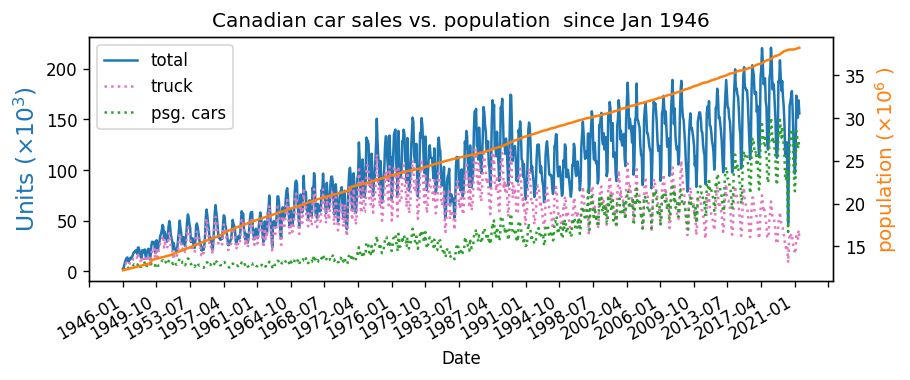

In [10]:
# Plot the sample data 
# change data to array
month_cs,units_cs_total = df_to_array(CS_df_u,1)
month_cs,units_cs_truck = df_to_array(CS_df_truck_u,1)
month_cs,units_cs_psg = df_to_array(CS_df_psg_u,1)
month_ppl,units_ppl = df_to_array(PPL_df_can,1)
# make the plot
fig, ax = plt.subplots(figsize=(8,3),dpi=120)
# left y-axis: car sales
ax.plot(month_cs,units_cs_total/1000,color="tab:blue", linestyle='-')
ax.plot(month_cs,units_cs_psg/1000,color="tab:pink", linestyle=':')
ax.plot(month_cs,units_cs_truck/1000,color="tab:green", linestyle=':')
ax.legend(['total','truck','psg. cars'])
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 45))
fig.autofmt_xdate()
plt.xlabel('Date')
plt.ylabel(r'Units ($\times 10^3$)',color="tab:blue",fontsize=14)
plt.title('Canadian car sales vs. population  since Jan 1946')

# # twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(month_ppl, units_ppl/1e6,color="tab:orange", linestyle='-')
ax2.set_ylabel(r"population ($\times 10^6$ )",color="tab:orange",fontsize=12)
ax2.xaxis.set_ticks(np.arange(start, end, 45))
ax2.get_xaxis().set_visible(False)

## LSTM deployment

In [ ]:
# Import ML librarires
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# fix random seed for reproducibility
# np.random.seed(3)

In [ ]:
# preliminary results
# Predict length  
total_mon = len(month_cs)
ind_mon_set = np.linspace(1,len(month_cs),len(month_cs))
mon_past = 12
mon_future = 6

# normalize the dataset
def normalize_ts(ts_input):
    min_ts = np.min(ts_input)
    max_ts = np.max(ts_input)
    diff_min_max = max_ts - min_ts
    ts_scaled = (ts_input - min_ts)/(max_ts - min_ts)
    return ts_scaled, diff_min_max, min_ts

def rescale_ts(normalized_ts,diff_min_max,min_units):
    ts_rescl = normalized_ts * diff_min_max + min_units
    return ts_rescl

units_cs_total_scl, diff_min_max_cs_total, min_cs_total = normalize_ts(units_cs_total)


In [ ]:
# split training and testing set
train_fac = 0.8
train_size = int(total_mon * train_fac)
test_size = total_mon - train_size
train, test = units_cs_total_scl[:train_size], units_cs_total_scl[train_size:total_mon]

In [ ]:
# convert an array of values into a dataset matrix
# changed to adapt look_forward >2, trim without padding, TP 11/15
def create_dataset(dataset, look_back = 1, look_forward = 1, n_features = 1):
	len_input = len(dataset)
	len_output = len_input - look_back - look_forward - 1
	dataX = np.empty([len_output, look_back, n_features])
	dataY = np.empty([len_output, look_forward, n_features])
	# dataX, dataY = [], []
	for i in range(len_output):
		a = dataset[i:(i+look_back)].reshape([look_back,n_features])
		b = dataset[(i+look_back):(i+look_back+look_forward)].reshape([look_forward,n_features])
		dataX[i] = a
		dataY[i] = b
	return np.array(dataX), np.array(dataY)


In [ ]:
#%% LSTM SET UP %%
# Hyper parameters

# dict_LSTM = {'look_back' : 6,
#              'look_forward' : 6,
#             'num_samples' : 1,
#             'num_features' : 1,
#             'LSTM_units' : 4,
#             'n_epochs': 7,
#             'n_batch': 1,
#             'n_verbose': 2,
#             'n_dense' : 1,
#             'optimizer' : 'adam',
#             'loss': 'mean_squared_error'}

def train_LSTM(trainX,trainY,testX,testY,dict_ts):
    # create and fit the LSTM network
    model = Sequential()
    model.add(LSTM(dict_ts['LSTM_units'], input_shape=(dict_ts['look_back'], dict_ts['num_features'])))
    model.add(Dense(dict_ts['n_dense']))
    model.compile(loss=dict_ts['loss'], optimizer=dict_ts['optimizer'])
    model.fit(trainX, trainY, epochs=dict_ts['n_epochs'], batch_size=dict_ts['n_batch'], verbose=dict_ts['n_verbose'])
    # make predictions
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    return trainPredict, testPredict

def train_LSTMx2(trainX,trainY,testX,testY,dict_ts):
    # create and fit the LSTM network
    model = Sequential()
    model.add(LSTM(dict_ts['LSTM_units'], input_shape=(dict_ts['look_back'], dict_ts['num_features']),activation='sigmoid'))
    model.add(Dense(2*dict_ts['n_dense']))
    model.add(Dense(dict_ts['n_dense']))
    model.compile(loss=dict_ts['loss'], optimizer=dict_ts['optimizer'])
    model.fit(trainX, trainY, epochs=dict_ts['n_epochs'], batch_size=dict_ts['n_batch'], verbose=dict_ts['n_verbose'])
    # make predictions
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    return trainPredict, testPredict

### Test 1: One-step prediction


In [ ]:
look_back = 24
look_forward = 6
dict_LSTM = {'look_back' : look_back,
             'look_forward' : look_forward,
            'num_samples' : 1,
            'num_features' : 1,
            'LSTM_units' : 96,
            'n_epochs': 12,
            'n_batch': 15,
            'n_verbose': 2,
            'n_dense' : look_forward,
            'optimizer' : 'adam',
            'loss': 'mean_squared_error'}
# reshape input to be [samples, time steps, features]
trainX, trainY = create_dataset(train, dict_LSTM['look_back'], dict_LSTM['look_forward'])
testX, testY = create_dataset(test, dict_LSTM['look_back'], dict_LSTM['look_forward'])
trainX = np.reshape(trainX, (trainX.shape[0], dict_LSTM['look_back'], dict_LSTM['num_features']))
testX = np.reshape(testX, (testX.shape[0], dict_LSTM['look_back'], dict_LSTM['num_features']))


trainPredict,testPredict = train_LSTMx2(trainX,trainY,testX,testY,dict_LSTM)

# invert predictions

trainPredict = rescale_ts(trainPredict,diff_min_max_cs_total,min_cs_total)
testPredict = rescale_ts(testPredict,diff_min_max_cs_total,min_cs_total)
trainY = rescale_ts(trainY,diff_min_max_cs_total,min_cs_total)
testY = rescale_ts(testY,diff_min_max_cs_total,min_cs_total)
trainX = rescale_ts(trainX,diff_min_max_cs_total,min_cs_total)
testX = rescale_ts(testX,diff_min_max_cs_total,min_cs_total)

Epoch 1/12
47/47 - 3s - loss: 0.1106 - 3s/epoch - 56ms/step
Epoch 2/12
47/47 - 1s - loss: 0.0336 - 863ms/epoch - 18ms/step
Epoch 3/12
47/47 - 1s - loss: 0.0308 - 872ms/epoch - 19ms/step
Epoch 4/12
47/47 - 1s - loss: 0.0301 - 869ms/epoch - 18ms/step
Epoch 5/12
47/47 - 1s - loss: 0.0272 - 871ms/epoch - 19ms/step
Epoch 6/12
47/47 - 1s - loss: 0.0254 - 891ms/epoch - 19ms/step
Epoch 7/12
47/47 - 1s - loss: 0.0221 - 878ms/epoch - 19ms/step
Epoch 8/12
47/47 - 1s - loss: 0.0198 - 873ms/epoch - 19ms/step
Epoch 9/12
47/47 - 1s - loss: 0.0166 - 858ms/epoch - 18ms/step
Epoch 10/12
47/47 - 1s - loss: 0.0158 - 865ms/epoch - 18ms/step
Epoch 11/12
47/47 - 1s - loss: 0.0128 - 867ms/epoch - 18ms/step
Epoch 12/12
47/47 - 1s - loss: 0.0125 - 899ms/epoch - 19ms/step


In [ ]:
def plot_test(imon,testX,testY,testPredict,dict_LSTM):
    plt_true = np.concatenate((np.squeeze(testX[imon]),np.squeeze(testY[imon])))
    plt_predict = np.concatenate((np.squeeze(testX[imon]),np.squeeze(testPredict[imon])))

    month = np.linspace(1,(dict_LSTM['look_back'] + dict_LSTM['look_forward']),(dict_LSTM['look_back'] + dict_LSTM['look_forward']))

    plt.plot(month,plt_true)
    plt.plot(month,plt_predict,'--')
    plt.legend(['true','prediction'])
    plt.title('test #'+str(imon))
    plt.show()


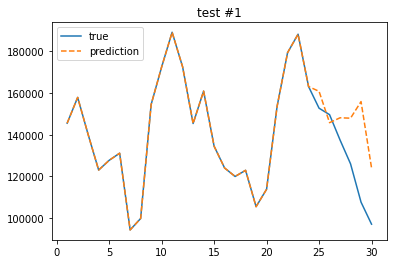

In [ ]:
plot_test(1,testX,testY,testPredict,dict_LSTM)
# plot_test(25,testX,testY,testPredict,dict_LSTM)
# plot_test(50,testX,testY,testPredict,dict_LSTM)
# plot_test(75,testX,testY,testPredict,dict_LSTM)
# plot_test(125,testX,testY,testPredict,dict_LSTM)
# plot_test(150,testX,testY,testPredict,dict_LSTM)

In [ ]:
# Plotting the results for 5 years
test_month = 60

plt.figure()

plt_predict = np.cast(testX[-test_month:],testY[predict])
                     
plt.plot(testY[-test_month-1:])
plt.plot(testPredict[-test_month:])
plt.xlabel('month')
plt.ylabel('units')
plt.title('Predicting last '+str(test_month)+' months of testing set, \n look_back = '
    + str(dict_LSTM['look_back'])+', look_forward = '+ str(dict_LSTM['look_forward'])+'\n'
    + 'epochs = '+str(dict_LSTM['n_epochs']) + ', batch = '+str(dict_LSTM['n_batch']))
plt.legend(['test','predict'])
plt.show()

NameError: ignored

<Figure size 432x288 with 0 Axes>

## Simple RNN deployment



In [ ]:
RNNmodel = keras.models.Sequential([keras.layers.SimpleRNN(1, input_shape=[None, 1])])
RNNmodel.compile(loss="mse")

RNNmodel.fit(trainX, trainY, epochs=20)

# RNNmodel.evaluate(X_valid, y_valid)

Epoch 1/20
22/22 [==============================] - 1s 5ms/step - loss: 9174349824.0000
Epoch 2/20
22/22 [==============================] - 0s 4ms/step - loss: 9174349824.0000
Epoch 3/20
22/22 [==============================] - 0s 4ms/step - loss: 9174352896.0000
Epoch 4/20
22/22 [==============================] - 0s 4ms/step - loss: 9174351872.0000
Epoch 5/20
22/22 [==============================] - 0s 5ms/step - loss: 9174350848.0000
Epoch 6/20
22/22 [==============================] - 0s 4ms/step - loss: 9174350848.0000
Epoch 7/20
22/22 [==============================] - 0s 4ms/step - loss: 9174351872.0000
Epoch 8/20
22/22 [==============================] - 0s 5ms/step - loss: 9174350848.0000
Epoch 9/20
22/22 [==============================] - 0s 5ms/step - loss: 9174350848.0000
Epoch 10/20
22/22 [==============================] - 0s 5ms/step - loss: 9174351872.0000
Epoch 11/20
22/22 [==============================] - 0s 5ms/step - loss: 9174351872.0000
Epoch 12/20
22/22 [===========